In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, roc_curve, auc
from sklearn.decomposition import PCA
from skimage.feature import hog
from skimage import exposure
from skimage.io import imread
from skimage.transform import resize
from imblearn.over_sampling import SMOTE
import warnings
from PIL import UnidentifiedImageError


In [2]:
# Set random seed for reproducibility
np.random.seed(42)


In [3]:

# Dataset path
dataset_dir = r'D:\food_set\food_set'
classes = ['sushi', 'cheesecake', 'baklava', 'caesar_salad', 'hamburger']
labels = []


In [4]:
# Function to load and resize images
def load_data(dataset_dir, classes, target_size=(128, 128)):
    data = []
    for class_name in classes:
        class_dir = os.path.join(dataset_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith(".jpg"):
                img_path = os.path.join(class_dir, filename)
                try:
                    with warnings.catch_warnings():
                        warnings.simplefilter("ignore", UserWarning)
                        img = imread(img_path)
                    img_resized = resize(img, target_size)  # Resize to target size
                    img_resized = img_resized.astype('float32') / 255.0  # Normalize
                    data.append(img_resized)
                    labels.append(class_name)
                except (UnidentifiedImageError, IOError) as e:
                    print(f"Skipping corrupted image: {img_path} - {e}")
    return np.array(data), labels


In [5]:
# Load data
X, labels = load_data(dataset_dir, classes)


In [7]:
# Display dataset details
# Number of classes and their labels
num_classes = len(classes)
print(f'Number of classes: {num_classes}')
print(f'Class labels: {classes}')

# Total number of samples in the dataset and size of each image
total_samples = len(labels)
print(f'Total number of samples: {total_samples}')

# Example image size (assuming all images are resized to (128, 128))
example_image_size = X[0].shape  # Shape of the first image
print(f'Image size (each image): {example_image_size}')


Number of classes: 5
Class labels: ['sushi', 'cheesecake', 'baklava', 'caesar_salad', 'hamburger']
Total number of samples: 5000
Image size (each image): (128, 128, 3)


In [8]:
# Convert labels to integers using LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)


In [9]:
# Extract HOG features from images
def extract_hog_features(images):
    hog_features = []
    for img in images:
        # Convert to grayscale
        gray_img = np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])  # Simple RGB to grayscale conversion
        # Extract HOG features
        fd, _ = hog(
            gray_img, 
            orientations=12, 
            pixels_per_cell=(16, 16), 
            cells_per_block=(3, 3), 
            visualize=True
        )
        hog_features.append(fd)
    return np.array(hog_features)


In [10]:

# Extract HOG features for all images
hog_features = extract_hog_features(X)


In [11]:
# Dimensionality reduction with PCA
pca = PCA(n_components=50)
hog_features_pca = pca.fit_transform(hog_features)

# Normalize features
scaler = StandardScaler()
hog_features_scaled = scaler.fit_transform(hog_features_pca)


In [13]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [14]:
from imblearn.over_sampling import SMOTE
# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(hog_features_scaled, y)


In [15]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.3, stratify=y_balanced, random_state=42
)


In [16]:
# The number of training and testing samples
train_samples = len(y_train)
test_samples = len(y_test)
print(f'Number of samples in training set: {train_samples}')
print(f'Number of samples in testing set: {test_samples}')


Number of samples in training set: 3500
Number of samples in testing set: 1500


In [17]:
# Perform hyperparameter tuning with GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['l2']
}
log_reg = LogisticRegression(max_iter=2000)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=2000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='accuracy')

In [18]:
# Best model
best_model = grid_search.best_estimator_


In [19]:
# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Optimized Accuracy: {accuracy:.4f}')


Optimized Accuracy: 0.4733


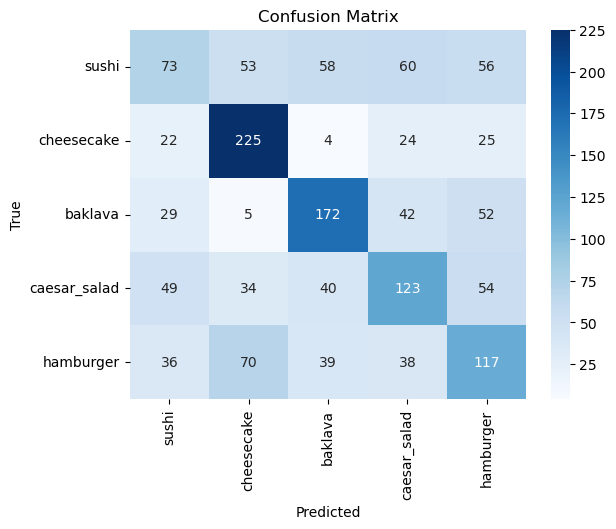

In [20]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [21]:
# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred, target_names=classes))


Classification Report:
              precision    recall  f1-score   support

       sushi       0.35      0.24      0.29       300
  cheesecake       0.58      0.75      0.66       300
     baklava       0.55      0.57      0.56       300
caesar_salad       0.43      0.41      0.42       300
   hamburger       0.38      0.39      0.39       300

    accuracy                           0.47      1500
   macro avg       0.46      0.47      0.46      1500
weighted avg       0.46      0.47      0.46      1500



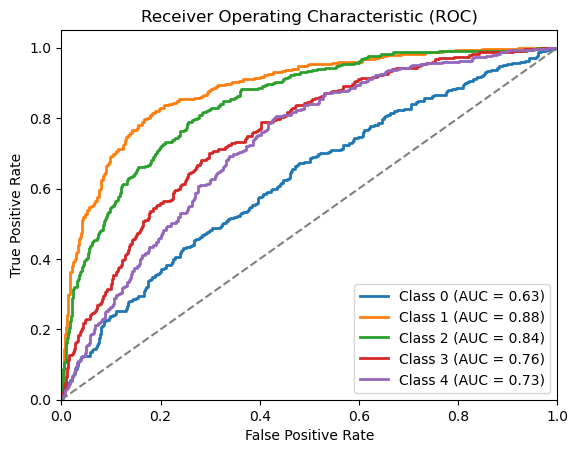

In [22]:
# ROC-AUC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
roc_aucs = []
for i in range(y_test_bin.shape[1]):
    fpr, tpr, thresholds = roc_curve(y_test_bin[:, i], best_model.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    roc_aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [23]:
# Precision and Recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Precision: 0.4587
Recall: 0.4733
